In [11]:
import numpy as np
import pandas as pd
import xgboost 

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
base_dir = "/content/drive/"
drive.mount(base_dir)

Mounted at /content/drive/


In [3]:
cd 'drive/MyDrive/Data/'

/content/drive/MyDrive/Data


In [4]:
seed = 15

In [33]:
# Load training dataset
Y_train_full = pd.read_csv('y_train.csv', index_col = 0, squeeze = True)
X_train_full = pd.read_csv('X_train.csv', index_col = 0, header=[0, 1, 2])
X_test = pd.read_csv('X_test.csv', index_col = 0, header=[0, 1, 2])

X_train, X_val, Y_train, Y_val = train_test_split(X_train_full,Y_train_full,
                                                  test_size = int(len(X_train_full.index)*0.2),
                                                  random_state=seed)

# scaled version
scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)

scaler_train_full = StandardScaler()
scaler_train_full.fit(X_train_full)
X_train_full = scaler_train_full.transform(X_train_full)

X_val = scaler_train_full.transform(X_val)
X_test = scaler_train_full.transform(X_test)

In [34]:
LDA = LinearDiscriminantAnalysis(n_components = 20)
LDA.fit(X_train, Y_train)
ZLDA_tr = LDA.transform(X_train)
ZLDA_te = LDA.transform(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(518, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [19]:
params = {'base_estimator':[DecisionTreeClassifier(max_depth=1)],
          'n_estimators':[100, 150],
          'learning_rate':[0.01,0.1]}

In [20]:
ada_grid = GridSearchCV(AdaBoostClassifier(), params, cv=5).fit(ZLDA_tr, Y_train)

In [21]:
ada_grid.best_params_

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'learning_rate': 0.1,
 'n_estimators': 150}

In [22]:
ada_grid.best_estimator_.score(ZLDA_te, Y_val)

0.5366666666666666

In [ ]:
lr = LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000).fit(X_train, Y_train)

Text(0, 0.5, 'Features count')

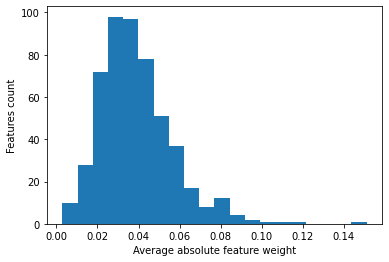

In [ ]:
feat_importance_lr = np.mean(np.abs(lr.coef_), axis=0)
plt.hist(feat_importance_lr, bins=20)
plt.xlabel("Average absolute feature weight")
plt.ylabel("Features count")

In [ ]:
# Select the 10%, 20% and 30% of most important features
index_lr = []
for val in np.quantile(feat_importance_lr, [0.9, 0.8, 0.7, 0.5]):
    index_lr.append(feat_importance_lr>val)
percent = ['10%', '20%', '30%']

In [28]:
params = {'min_samples_split': [30],
          'min_samples_leaf': [30],
          'n_estimators':[50,100,150,200],
          'max_depth': [2,3],
          'n_iter_no_change':[4],
          'tol':[5],
          }

In [35]:
grid_1 = GridSearchCV(GradientBoostingClassifier(verbose=1), params, cv=4).fit(ZLDA_tr, Y_train)

      Iter       Train Loss   Remaining Time 
         1        5978.9793            3.01s
         2        5477.9821            2.92s
         3        5119.1367            2.91s
         4        4838.4491            2.95s
         5        4599.5788            2.90s
         6        4409.0658            2.83s
         7        4244.1665            2.74s
         8        4083.7051            2.69s
         9        3943.8173            2.61s
        10        3832.5079            2.55s
        20        3111.9733            1.89s
        30        2797.2806            1.25s
      Iter       Train Loss   Remaining Time 
         1        5980.3943            2.93s
         2        5502.1136            2.88s
         3        5131.4165            2.85s
         4        4846.2833            2.83s
         5        4608.0665            2.76s
         6        4406.5731            2.69s
         7        4239.9385            2.63s
         8        4094.3557            2.59s
        

In [36]:
grid_1.best_params_

{'max_depth': 2, 'n_estimators': 150, 'n_iter_no_change': 4, 'tol': 5}

In [37]:
grid_1.best_estimator_.score(ZLDA_te, Y_val)

0.5358333333333334

In [ ]:
# grid_1.cv_results_

# {'mean_fit_time': array([ 8.93404001,  8.79187703,  9.03387874,  8.66064924,  9.70213675,
#          9.11781996,  9.02520406,  8.77966815,  9.57624096, 12.36644286,
#         10.81890446, 12.95555979, 12.73694038, 12.55540591, 12.60299182,
#         12.65318131, 12.144665  , 12.86109513]),
#  'mean_score_time': array([0.00693148, 0.00725389, 0.00704896, 0.0072872 , 0.00729257,
#         0.00731266, 0.00739968, 0.00801289, 0.00721109, 0.00947422,
#         0.00794256, 0.00881124, 0.00862771, 0.00995046, 0.0085029 ,
#         0.00899899, 0.00860226, 0.00897908]),
#  'mean_test_score': array([0.48854167, 0.484375  , 0.49083333, 0.48520833, 0.48854167,
#         0.49166667, 0.48854167, 0.49      , 0.493125  , 0.50645833,
#         0.49458333, 0.50958333, 0.50708333, 0.50583333, 0.50583333,
#         0.50479167, 0.51166667, 0.50791667]),
#  'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_min_samples_leaf': masked_array(data=[10, 10, 10, 25, 25, 25, 50, 50, 50, 10, 10, 10, 25, 25,
#                     25, 50, 50, 50],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_min_samples_split': masked_array(data=[10, 25, 50, 10, 25, 50, 10, 25, 50, 10, 25, 50, 10, 25,
#                     50, 10, 25, 50],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_n_iter_no_change': masked_array(data=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_tol': masked_array(data=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
#                     10, 10, 10, 10],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'params': [{'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 10},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 10}],
#  'rank_test_score': array([14, 18, 12, 17, 14, 11, 14, 13, 10,  5,  9,  2,  4,  6,  6,  8,  1,
#          3], dtype=int32),
#  'split0_test_score': array([0.5       , 0.49333333, 0.50333333, 0.5025    , 0.5075    ,
#         0.49833333, 0.495     , 0.5       , 0.49666667, 0.52166667,
#         0.50833333, 0.52      , 0.51916667, 0.50583333, 0.50833333,
#         0.51916667, 0.51416667, 0.52      ]),
#  'split1_test_score': array([0.47333333, 0.4675    , 0.475     , 0.475     , 0.47083333,
#         0.4725    , 0.48083333, 0.4925    , 0.4875    , 0.49833333,
#         0.4775    , 0.49416667, 0.5       , 0.50166667, 0.50583333,
#         0.49083333, 0.50083333, 0.49      ]),
#  'split2_test_score': array([0.4825    , 0.48583333, 0.48416667, 0.48083333, 0.47916667,
#         0.4925    , 0.47916667, 0.4825    , 0.48833333, 0.5025    ,
#         0.49666667, 0.515     , 0.51416667, 0.50166667, 0.495     ,
#         0.50083333, 0.51083333, 0.51      ]),
#  'split3_test_score': array([0.49833333, 0.49083333, 0.50083333, 0.4825    , 0.49666667,
#         0.50333333, 0.49916667, 0.485     , 0.5       , 0.50333333,
#         0.49583333, 0.50916667, 0.495     , 0.51416667, 0.51416667,
#         0.50833333, 0.52083333, 0.51166667]),
#  'std_fit_time': array([0.22577208, 0.82009772, 0.75802985, 0.2830218 , 0.53138021,
#         0.85601547, 0.1506581 , 0.66987083, 0.97026518, 0.36190577,
#         0.77389837, 1.12468099, 0.76640923, 0.41329104, 1.05061848,
#         1.01799759, 0.83846573, 0.59705631]),
#  'std_score_time': array([0.00018649, 0.00043404, 0.00040631, 0.00071553, 0.00023543,
#         0.00066491, 0.00083165, 0.00100832, 0.00044708, 0.00126943,
#         0.00045676, 0.00032131, 0.00053494, 0.001765  , 0.00041123,
#         0.00071358, 0.00015136, 0.00030314]),
#  'std_test_score': array([0.01112391, 0.01011007, 0.01174084, 0.01036445, 0.01437802,
#         0.01171122, 0.00868777, 0.00684653, 0.00534812, 0.00898253,
#         0.01103184, 0.00969142, 0.00990405, 0.0051031 , 0.00694722,
#         0.01036445, 0.00721688, 0.01101609])}

In [ ]:
grid_2 = GridSearchCV(GradientBoostingClassifier(verbose=1), params, cv=4).fit(X_train[:,index_lr[1]], Y_train)

In [ ]:
# grid_2.cv_results_
# {'mean_fit_time': array([27.16780633, 26.0164023 , 30.87720931, 25.5666008 , 25.81546462,
#         27.92324245, 27.47240359, 28.96973222, 29.00225163, 34.28876245,
#         34.37783498, 34.99544972, 37.74826443, 36.93976873, 32.97170633,
#         33.65310884, 37.33343965, 34.5497449 ]),
#  'mean_score_time': array([0.00932974, 0.00910515, 0.01004976, 0.00952554, 0.00904602,
#         0.00968659, 0.00953054, 0.00985366, 0.00998038, 0.011186  ,
#         0.01081496, 0.01095653, 0.01164329, 0.01158917, 0.01087677,
#         0.01118273, 0.01181936, 0.01139891]),
#  'mean_test_score': array([0.52916667, 0.521875  , 0.52729167, 0.51895833, 0.519375  ,
#         0.523125  , 0.523125  , 0.53104167, 0.52291667, 0.53145833,
#         0.53708333, 0.53875   , 0.54645833, 0.54208333, 0.53666667,
#         0.53625   , 0.54479167, 0.53458333]),
#  'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_min_samples_leaf': masked_array(data=[10, 10, 10, 25, 25, 25, 50, 50, 50, 10, 10, 10, 25, 25,
#                     25, 50, 50, 50],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_min_samples_split': masked_array(data=[10, 25, 50, 10, 25, 50, 10, 25, 50, 10, 25, 50, 10, 25,
#                     50, 10, 25, 50],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_n_iter_no_change': masked_array(data=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_tol': masked_array(data=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'params': [{'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 10,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 25,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 2,
#    'min_samples_leaf': 50,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 10,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 25,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 10,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 25,
#    'n_iter_no_change': 4,
#    'tol': 5},
#   {'max_depth': 3,
#    'min_samples_leaf': 50,
#    'min_samples_split': 50,
#    'n_iter_no_change': 4,
#    'tol': 5}],
#  'rank_test_score': array([11, 16, 12, 18, 17, 14, 13, 10, 15,  9,  5,  4,  1,  3,  6,  7,  2,
#          8], dtype=int32),
#  'split0_test_score': array([0.54416667, 0.51583333, 0.52583333, 0.53083333, 0.5225    ,
#         0.53166667, 0.52833333, 0.53666667, 0.53166667, 0.54      ,
#         0.5425    , 0.535     , 0.545     , 0.53833333, 0.525     ,
#         0.5325    , 0.53583333, 0.53666667]),
#  'split1_test_score': array([0.5275    , 0.52333333, 0.525     , 0.51333333, 0.51      ,
#         0.5275    , 0.5175    , 0.52916667, 0.52583333, 0.53666667,
#         0.53583333, 0.52833333, 0.54166667, 0.54166667, 0.5425    ,
#         0.53083333, 0.5425    , 0.5325    ]),
#  'split2_test_score': array([0.53333333, 0.52416667, 0.53833333, 0.525     , 0.53083333,
#         0.5275    , 0.53166667, 0.5375    , 0.51916667, 0.53583333,
#         0.5375    , 0.555     , 0.55916667, 0.54166667, 0.54      ,
#         0.54083333, 0.55166667, 0.54166667]),
#  'split3_test_score': array([0.51166667, 0.52416667, 0.52      , 0.50666667, 0.51416667,
#         0.50583333, 0.515     , 0.52083333, 0.515     , 0.51333333,
#         0.5325    , 0.53666667, 0.54      , 0.54666667, 0.53916667,
#         0.54083333, 0.54916667, 0.5275    ]),
#  'std_fit_time': array([2.4474773 , 0.9102013 , 1.36826092, 2.66161063, 0.34336334,
#         3.02011083, 3.12549498, 2.47684633, 4.81728638, 2.76402844,
#         3.12439083, 2.86339826, 3.7221499 , 1.35213348, 3.93754582,
#         3.54346396, 4.07673654, 2.28622069]),
#  'std_score_time': array([4.25952403e-04, 1.75274742e-04, 2.88310341e-04, 8.76077106e-04,
#         6.18532824e-05, 3.66105547e-04, 6.85122244e-04, 5.59760351e-04,
#         1.07715562e-03, 9.75080755e-04, 6.81569631e-04, 5.22979264e-04,
#         7.57293533e-04, 4.98133430e-04, 9.04340064e-04, 9.01277123e-04,
#         8.43572575e-04, 5.65782874e-04]),
#  'std_test_score': array([0.01174084, 0.00350471, 0.00675399, 0.00949003, 0.00800119,
#         0.01012723, 0.00703106, 0.00672823, 0.00636014, 0.01057997,
#         0.00360844, 0.00988651, 0.00755478, 0.0029756 , 0.00684653,
#         0.00462106, 0.00616258, 0.00522082])}

{'mean_fit_time': array([27.16780633, 26.0164023 , 30.87720931, 25.5666008 , 25.81546462,
        27.92324245, 27.47240359, 28.96973222, 29.00225163, 34.28876245,
        34.37783498, 34.99544972, 37.74826443, 36.93976873, 32.97170633,
        33.65310884, 37.33343965, 34.5497449 ]),
 'mean_score_time': array([0.00932974, 0.00910515, 0.01004976, 0.00952554, 0.00904602,
        0.00968659, 0.00953054, 0.00985366, 0.00998038, 0.011186  ,
        0.01081496, 0.01095653, 0.01164329, 0.01158917, 0.01087677,
        0.01118273, 0.01181936, 0.01139891]),
 'mean_test_score': array([0.52916667, 0.521875  , 0.52729167, 0.51895833, 0.519375  ,
        0.523125  , 0.523125  , 0.53104167, 0.52291667, 0.53145833,
        0.53708333, 0.53875   , 0.54645833, 0.54208333, 0.53666667,
        0.53625   , 0.54479167, 0.53458333]),
 'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
       

In [ ]:
for i, index in enumerate(index_lr):
    gradboost = GradientBoostingClassifier(min_samples_leaf=50,
                                           min_samples_split=50,
                                           max_depth=3,
                                           n_iter_no_change=3,
                                           tol=10,
                                           verbose=1).fit(X_train[:,index], Y_train)
    print('With the {} most important features'.format(percent[i]))
    print("Train score: ", gradboost.score(X_train[:,index], Y_train))
    print("Validation score: ", gradboost.score(X_val[:,index], Y_val), "\n")

# max_features = int(len(index)**0.3)

      Iter       Train Loss   Remaining Time 
         1        8492.9374            1.09m
         2        8106.4064            1.08m
         3        7800.6116            1.08m
         4        7551.7473            1.06m
         5        7324.2393            1.06m
         6        7119.2378            1.04m
         7        6946.8298            1.03m
         8        6786.7348            1.01m
         9        6641.9003            1.00m
        10        6511.8466           59.62s
        20        5570.8887           52.69s
With the 10% most important features
Train score:  0.6389583333333333
Validation score:  0.52 

      Iter       Train Loss   Remaining Time 
         1        8421.3230            2.22m
         2        8007.2835            2.20m
         3        7688.3495            2.17m
         4        7402.9062            2.13m
         5        7154.3548            2.10m
         6        6943.3854            2.07m
         7        6756.0306            2.05m
  

In [ ]:
ada = AdaBoostClassifier()
ada_rfcev = RFECV(ada, min_features_to_select=25, step=20, cv=5, verbose=1)

ada_rfcev = ada_rfcev.fit(X_train[:,index_lr[3]], Y_train)

Fitting estimator with 259 features.
Fitting estimator with 239 features.
Fitting estimator with 219 features.
Fitting estimator with 199 features.
Fitting estimator with 179 features.
Fitting estimator with 159 features.
Fitting estimator with 139 features.
Fitting estimator with 119 features.
Fitting estimator with 99 features.
Fitting estimator with 79 features.
Fitting estimator with 59 features.
Fitting estimator with 39 features.
Fitting estimator with 259 features.
Fitting estimator with 239 features.
Fitting estimator with 219 features.
Fitting estimator with 199 features.
Fitting estimator with 179 features.
Fitting estimator with 159 features.
Fitting estimator with 139 features.
Fitting estimator with 119 features.
Fitting estimator with 99 features.
Fitting estimator with 79 features.
Fitting estimator with 59 features.
Fitting estimator with 39 features.
Fitting estimator with 259 features.
Fitting estimator with 239 features.
Fitting estimator with 219 features.
Fitting e

In [ ]:
ada_rfcev.grid_scores_
# ada_rfcev.n_features_ = 39
ada_rfcev.support_
# array([0.40541667, 0.41958333, 0.41375   , 0.41375   , 0.41375   ,
#        0.41375   , 0.41375   , 0.41375   , 0.41375   , 0.41375   ,
#        0.41375   , 0.41375   , 0.41375   ])

# array([False, False, False, False, False,  True, False, False, False,
#        False, False,  True, False, False,  True, False, False, False,
#        False, False, False, False, False, False, False, False, False,
#        False, False, False, False, False, False, False,  True, False,
#        False, False, False, False, False, False, False, False, False,
#        False, False, False, False, False,  True, False, False,  True,
#        False, False, False, False, False, False, False, False, False,
#        False, False, False, False, False, False, False, False,  True,
#        False, False, False, False, False,  True, False, False, False,
#        False,  True, False, False, False, False, False, False,  True,
#         True, False, False, False, False, False, False, False,  True,
#        False,  True, False, False, False, False, False,  True, False,
#        False,  True, False, False,  True, False,  True, False,  True,
#        False, False, False, False, False,  True, False, False,  True,
#        False,  True, False, False, False, False, False,  True, False,
#         True, False, False, False, False, False, False, False, False,
#        False, False, False, False, False, False, False,  True, False,
#        False, False, False, False, False, False, False, False, False,
#        False, False, False, False,  True, False, False, False, False,
#        False, False, False, False, False, False, False,  True, False,
#        False, False, False, False, False, False, False, False, False,
#        False, False, False, False, False, False, False, False,  True,
#        False, False, False, False, False, False, False,  True,  True,
#        False, False, False,  True, False, False, False, False, False,
#        False, False,  True, False, False, False, False, False,  True,
#         True, False, False, False, False, False,  True, False, False,
#        False, False, False, False, False, False,  True,  True, False,
#        False, False, False, False,  True, False, False, False, False,
#         True, False, False,  True, False, False, False])

array([False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False,  True,
       False, False, False, False, False,  True, False, False,  True,
       False,  True,

In [ ]:
rf = RandomForestClassifier(max_depth= 3,
                            min_samples_leaf= 25,
                            min_samples_split= 10)
rf_rfcev = RFECV(rf, min_features_to_select=20, step=25, cv=4, verbose=1)

rf_rfcev = rf_rfcev.fit(X_train[:,index_lr[3]], Y_train)

Fitting estimator with 259 features.
Fitting estimator with 234 features.
Fitting estimator with 209 features.
Fitting estimator with 184 features.
Fitting estimator with 159 features.
Fitting estimator with 134 features.
Fitting estimator with 109 features.
Fitting estimator with 84 features.
Fitting estimator with 59 features.
Fitting estimator with 34 features.
Fitting estimator with 259 features.
Fitting estimator with 234 features.
Fitting estimator with 209 features.
Fitting estimator with 184 features.
Fitting estimator with 159 features.
Fitting estimator with 134 features.
Fitting estimator with 109 features.
Fitting estimator with 84 features.
Fitting estimator with 59 features.
Fitting estimator with 34 features.
Fitting estimator with 259 features.
Fitting estimator with 234 features.
Fitting estimator with 209 features.
Fitting estimator with 184 features.
Fitting estimator with 159 features.
Fitting estimator with 134 features.
Fitting estimator with 109 features.
Fitting

In [ ]:
rf_rfcev.grid_scores_ 

# array([0.39375   , 0.40604167, 0.41395833, 0.41458333, 0.42625   ,
#        0.42645833, 0.42875   , 0.43083333, 0.4275    , 0.43166667,
#        0.43375   ])

rf_rfcev.n_features_


259

In [ ]:
gradboost_opt = GradientBoostingClassifier(min_samples_leaf=50,
                                           min_samples_split=50,
                                           max_depth=3,
                                           verbose=1).fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 


KeyboardInterrupt: ignored

In [ ]:
print("Train score: ", gradboost_opt.score(X_train, Y_train))
print("Val score: ", gradboost_opt.score(X_val, Y_val))

Train score:  0.7083333333333334
Val score:  0.5441666666666667


In [ ]:
param_opt_xgb = xgboost.XGBClassifier(max_depth=3, min_samples_split=100, min_samples_leaf=100, gamma=5, verbose=2, n_estimators=60).fit(X_train, Y_train)

In [ ]:
print("Train score: ", param_opt_xgb.score(X_train, Y_train))
print("Val score: ", param_opt_xgb.score(X_val, Y_val))
# Train score:  0.8260416666666667 max depth=3
# Val score:  0.5475
# Train score:  0.6908333333333333 max depth=2
# Val score:  0.5308333333333334
# Train score:  0.7933333333333333
# Val score:  0.5466666666666666

Train score:  0.7370833333333333
Val score:  0.5333333333333333


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
sel_ = SelectFromModel(LogisticRegression( alpha=0.5))
sel_.fit(X_train, Y_train)

TypeError: ignored

In [ ]:
X_light = sel_.transform(X_train)
X_light_val = sel_.transform(X_val)

In [ ]:
mdl = RidgeClassifier().fit(X_train, Y_train)
filter = (np.sum(np.abs(mdl.coef_), axis=0)>0.2)
np.sum(filter)

308

In [ ]:
X_light = X_train[:,filter]
X_light_val = X_val[:,filter]

In [ ]:
param_opt_xgb = xgboost.XGBClassifier(max_depth=2, min_samples_split=100, min_samples_leaf=100, verbose=2, n_estimators=50).fit(X_light, Y_train)

In [ ]:
print("Train score: ", param_opt_xgb.score(X_light, Y_train))
print("Val score: ", param_opt_xgb.score(X_light_val, Y_val))

Train score:  0.6129166666666667
Val score:  0.49083333333333334


In [ ]:
param_opt_xgb = xgboost.XGBClassifier(max_depth=2, min_samples_split=50, min_samples_leaf=50, verbose=2, n_estimators=50).fit(X_train, Y_train)

In [ ]:
print("Train score: ", param_opt_xgb.score(X_train, Y_train))
print("Val score: ", param_opt_xgb.score(X_val, Y_val))

Train score:  0.6129166666666667
Val score:  0.49083333333333334


In [ ]:
sel_.get_support().sum()

159

In [ ]:
from sklearn.feature_selection import RFECV
estimator = xgboost.XGBClassifier(max_depth=2,verbosity=1, min_samples_split=50, min_samples_leaf=50)
selector = RFECV(estimator, step=20, cv=2, min_features_to_select=10, n_jobs=-1, verbose=2)
selector = selector.fit(X_train, Y_train)

Fitting estimator with 518 features.
Fitting estimator with 498 features.
Fitting estimator with 478 features.
Fitting estimator with 458 features.
Fitting estimator with 438 features.
Fitting estimator with 418 features.
Fitting estimator with 398 features.
Fitting estimator with 378 features.
Fitting estimator with 358 features.
Fitting estimator with 338 features.
Fitting estimator with 318 features.
Fitting estimator with 298 features.
Fitting estimator with 278 features.
Fitting estimator with 258 features.


In [ ]:
print("Train score: ", selector.score(X_train, Y_train))
print("Val score: ", selector.score(X_val, Y_val))

Train score:  0.6879166666666666
Val score:  0.5316666666666666


Optimal number of features : 314


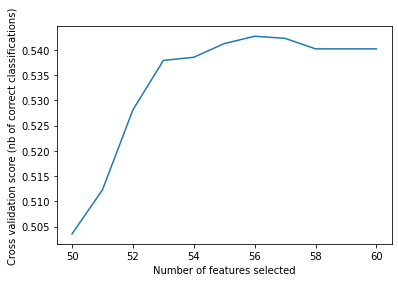

In [ ]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(50,
               len(selector.grid_scores_) + 50),
         selector.grid_scores_)
plt.show()